In [1]:
import numpy as np
import torch
from random import choices
from imageio import imread
from matplotlib import pyplot as plt
from geomloss import SamplesLoss
import time

use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor


def load_image(fname):
    img = imread(fname, mode='F')  # Grayscale
    img = (img[::-1, :]) / 255.0
    return  (1-img)


def draw_samples(fname, n, dtype=torch.FloatTensor):
    A = load_image(fname)

    xg, yg = np.meshgrid(
        np.linspace(0, 1, A.shape[0]),
        np.linspace(0, 1, A.shape[1]),
        indexing="ij",
    )


    grid = list(zip(xg.ravel(), yg.ravel()))
    dens = A.ravel() / A.sum()
    dots = np.array(choices(grid, dens, k=n))
    dots += (0.5 / A.shape[0]) * np.random.standard_normal(dots.shape)

    return torch.from_numpy(dots).type(dtype)


def display_samples(ax, x, color):
    x_ = x.detach().cpu().numpy()
    ax.scatter(x_[:, 0], x_[:, 1], 25 * 500 / len(x_), color, edgecolors="none")

[KeOps] Warning : omp.h header is not in the path, disabling OpenMP. To fix this, you can set the environment
                  variable OMP_PATH to the location of the header before importing keopscore or pykeops,
                  e.g. using os.environ: import os; os.environ['OMP_PATH'] = '/path/to/omp/header'
[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


In [2]:
def gradient_flow(loss, lr=0.05):
    """Flows along the gradient of the cost function, using a simple Euler scheme.

    Parameters:
        loss ((x_i,y_j) -> torch float number):
            Real-valued loss function.
        lr (float, default = .05):
            Learning rate, i.e. time step.
    """

    # Parameters for the gradient descent
    Nsteps = int(5 / lr) + 1
    display_its = [int(t / lr) for t in [0, 0.1, 0.2, 0.3 ,0.4, 0.5, 0.6, 1.0 ,2.0  ] ]

    # Use colors to identify the particles
    colors = (10 * X_i[:, 0]).cos() * (10 * X_i[:, 1]).cos()
    colors = colors.detach().cpu().numpy()

    # Make sure that we won't modify the reference samples
    x_i, y_j = X_i.clone(), Y_j.clone()

    # We're going to perform gradient descent on Loss(α, β)
    # wrt. the positions x_i of the diracs masses that make up α:
    x_i.requires_grad = True

    t_0 = time.time()
    plt.figure(figsize=(15, 15))
    k = 1
    for i in range(Nsteps):  # Euler scheme ===============
        # Compute cost and gradient
        L_αβ = loss(x_i, y_j)
        [g] = torch.autograd.grad(L_αβ, [x_i])

        if i in display_its:  # display
            ax = plt.subplot(3, 3, k)
            k = k + 1
            plt.set_cmap("hsv")
            plt.scatter(
                [10], [10]
            )  # shameless hack to prevent a slight change of axis...

            display_samples(ax, y_j, [(0.55, 0.55, 0.95)])
            display_samples(ax, x_i, colors)

            ax.set_title("t = {:1.2f}".format(lr * i))

            plt.axis([0, 1, 0, 1])
            plt.gca().set_aspect("equal", adjustable="box")
            plt.xticks([], [])
            plt.yticks([], [])
            plt.tight_layout()

        # in-place modification of the tensor's values
        x_i.data -= lr * len(x_i) * g
    plt.title(
        "t = {:1.2f}, elapsed time: {:.2f}s/it".format(
            lr * i, (time.time() - t_0) / Nsteps
        )
    )

In [3]:
source  = load_image('target.png')

/var/folders/b2/75ym41yx3ysd_01qq9wv2q1h0000gn/T/ipykernel_17362/3580815966.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(fname, mode='F')  # Grayscale


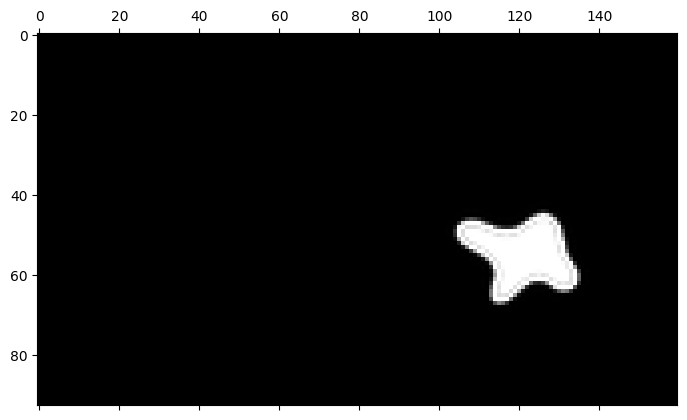

In [4]:
plt.matshow(source, cmap='gray')

In [45]:
N, M = (3000, 3000) 
A = load_image("source.png")
X_i = draw_samples("source.png", N, dtype)
Y_j = draw_samples("target.png", M, dtype)


/var/folders/b2/75ym41yx3ysd_01qq9wv2q1h0000gn/T/ipykernel_63395/3580815966.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(fname, mode='F')  # Grayscale


/var/folders/b2/75ym41yx3ysd_01qq9wv2q1h0000gn/T/ipykernel_63395/3580815966.py:39: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x_[:, 0], x_[:, 1], 25 * 500 / len(x_), color, edgecolors="none")


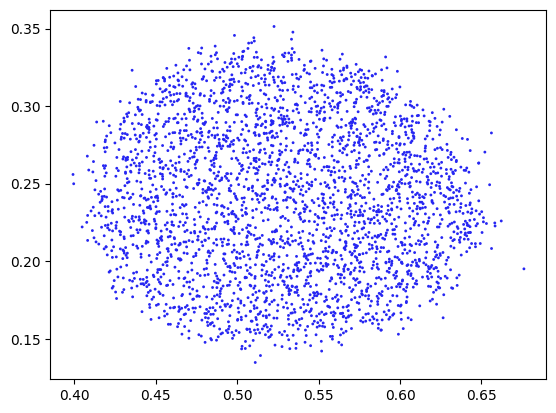

In [46]:
display_samples(plt.subplot(), X_i, [0.15,0.15,0.95])

/var/folders/b2/75ym41yx3ysd_01qq9wv2q1h0000gn/T/ipykernel_63395/3580815966.py:39: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x_[:, 0], x_[:, 1], 25 * 500 / len(x_), color, edgecolors="none")


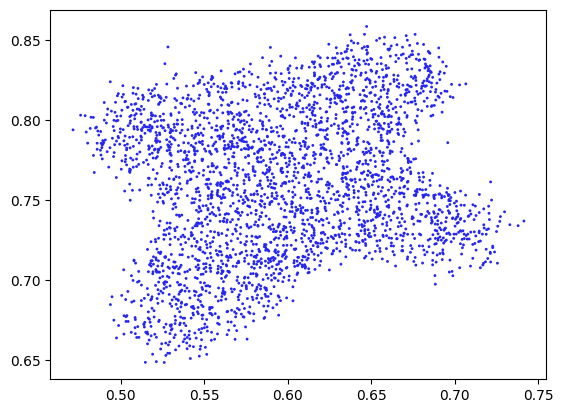

In [47]:
display_samples(plt.subplot(), Y_j, [0.15,0.15,0.95])

/var/folders/b2/75ym41yx3ysd_01qq9wv2q1h0000gn/T/ipykernel_63395/3373516687.py:51: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


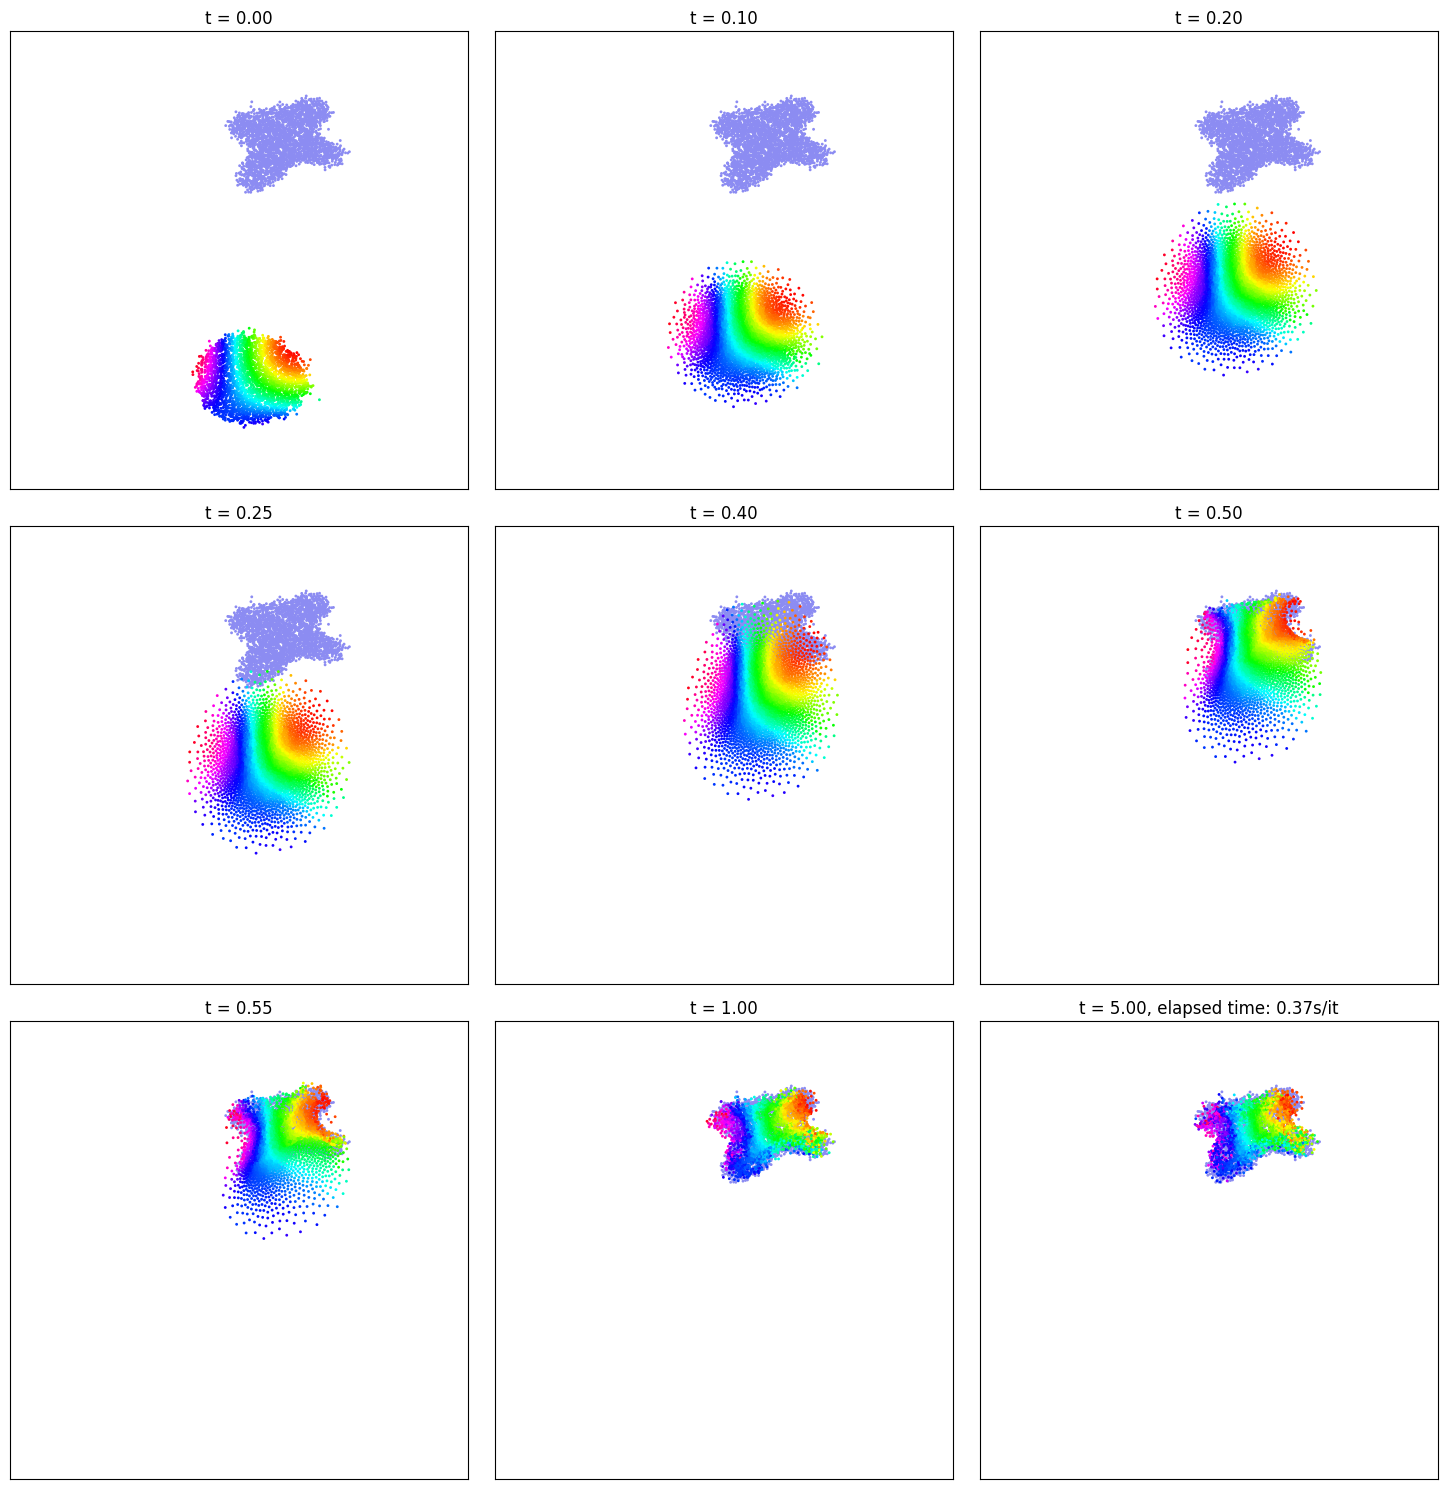

In [49]:
gradient_flow(SamplesLoss("sinkhorn", p=1, blur=0.01))